In [1]:
# %matplotlib widget
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

seaborn.set(context="notebook", style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 6)
from tqdm.auto import tqdm, trange

from ssptools import evolve_mf_3 as emf3
from limepy import *
from scipy.signal import convolve
import numpy as np
import scipy
import scipy as sp
import pandas as pd
from scipy.interpolate import BPoly, interp1d, UnivariateSpline
from numpy import exp, sqrt, pi, sin, cos, log10
from scipy.special import gamma, gammainc, hyp1f1
from scipy.integrate import ode, simpson, quad
from math import factorial, sinh
import astropy.units as u
from astropy.constants import c
from astropy.table import QTable
from astropy.io import ascii

In [2]:
import fitter
from fitter.probabilities.pulsars import *

In [20]:
spins_data = QTable.read("47Tuc_spin_periods.dat",format="ascii.csv")

In [21]:
spins_data

col0,P,Pdot_meas,id,r,ΔP,ΔPdot_meas,sigma_P,sigma_Pdot
int64,float64,float64,str15,float64,float64,float64,float64,float64
0,0.0037046394947985004,9.82e-21,b'J0024-7204ab',0.2092,5e-16,8e-24,5e-16,8e-24
1,0.0057567799955164,-4.985e-20,b'J0024-7204c',1.2298,1.0000000000000001e-16,2e-24,1.0000000000000001e-16,2e-24
2,0.00535757328486572,-3.4219e-21,b'J0024-7204D',0.6483,7e-17,9e-25,7e-17,9e-25
3,0.0035363291527624303,9.85103e-20,b'J0024-7204E',0.6205,3e-17,5e-25,3e-17,5e-25
4,0.00262357935251262,6.45031e-20,b'J0024-7204F',0.2149,3e-17,7e-25,3e-17,7e-25
5,0.0040403791435651,-4.2159e-20,b'J0024-7204G',0.2781,1.0000000000000001e-16,2e-24,1.0000000000000001e-16,2e-24
6,0.0032103407093504004,-1.83e-21,b'J0024-7204H',0.7677,1.0000000000000001e-16,1e-24,1.0000000000000001e-16,1e-24
7,0.0034849920616629,-4.5873e-20,b'J0024-7204I',0.2772,1.0000000000000001e-16,2e-24,1.0000000000000001e-16,2e-24
8,0.00210063354535248,-9.7919e-21,b'J0024-7204J',1.0185,6e-17,9e-25,6e-17,9e-25


In [22]:
spins_data["r"] <<= u.pc
spins_data["P"] <<= u.s


In [7]:
m123 = [0.1, 0.5, 1.0, 100]  # Slope breakpoints for initial mass function
a12 = [-0.49, -0.56, -2.58]  # Slopes for initial mass function
nbin12 = [5, 5, 20]

# Output times for the evolution
tout = np.array(
    [
        11000,
    ]
)
# tout = np.array([11000])

# Integration settings
N0 = 5e5  # Normalization of stars
Ndot = -0.0001  # Regulates how low mass objects are depleted default -20, 0 for 47 Tuc
tcc = 0  # Core collapse time
NS_ret = 0.1  # Initial neutron star retention
BH_ret_int = 1  # Initial Black Hole retention
BH_ret_dyn = 0.00235  # Dynamical Black Hole retention
FeHe = -0.7  # Metallicity

In [8]:
f = emf3.evolve_mf(
    m123=m123,
    a12=a12,
    nbin12=nbin12,
    tout=tout,
    N0=N0,
    Ndot=Ndot,
    tcc=tcc,
    NS_ret=NS_ret,
    BH_ret_int=BH_ret_int,
    BH_ret_dyn=BH_ret_dyn,
    FeHe=FeHe,
    natal_kicks=True,
    vesc=150,
)

/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/ssptools/evolve_mf_3.py:321: RuntimeWarning: divide by zero encountered in true_divide
  As = Ns / P1


In [9]:
cs = f.Ns[-1] > 10 * f.Nmin
cr = f.Nr[-1] > 10 * f.Nmin
mj = np.r_[f.ms[-1][cs], f.mr[-1][cr]]
Mj = np.r_[f.Ms[-1][cs], f.Mr[-1][cr]]
dms = f.mes[-1][1:] - f.mes[-1][0:-1]
nms = len(f.ms[-1][cs])
# Add in bin of 1.6 MSol to use to model MSPs
mj = np.append(mj, 1.6)
Mj = np.append(Mj, 0.1)

In [10]:
%time m = limepy(phi0=6.3, g=0.84,ra = 10**1.28,mj=mj,Mj=Mj, rh=7.47,M=0.967e6,delta=0.45,verbose=False, project=True)

CPU times: user 3.55 s, sys: 0 ns, total: 3.55 s
Wall time: 3.55 s


In [11]:
G_units = u.Unit('(pc km2) / (s2 Msun)')
R_units = u.pc
M_units = u.Msun
V2_units = G_units * M_units / R_units

m.G <<= G_units

m.M <<= M_units
m.mj <<= M_units
m.Mj <<= M_units
m.mc <<= M_units

m.r <<= R_units
m.rh <<= R_units
m.rt <<= R_units
m.ra <<= R_units

m.v2Tj <<= V2_units
m.v2Rj <<= V2_units
m.v2pj <<= V2_units

m.rhoj <<= (M_units / R_units**3)
m.Sigmaj <<= (M_units / R_units**2)

m.d = 4.45
m.d <<= u.kpc

In [12]:
a_space = np.linspace(-20e-9, 20e-9, 5000)

In [25]:
pdot, Paz = cluster_component(model=m, R=spins_data[1]["r"],mass_bin=-1 )

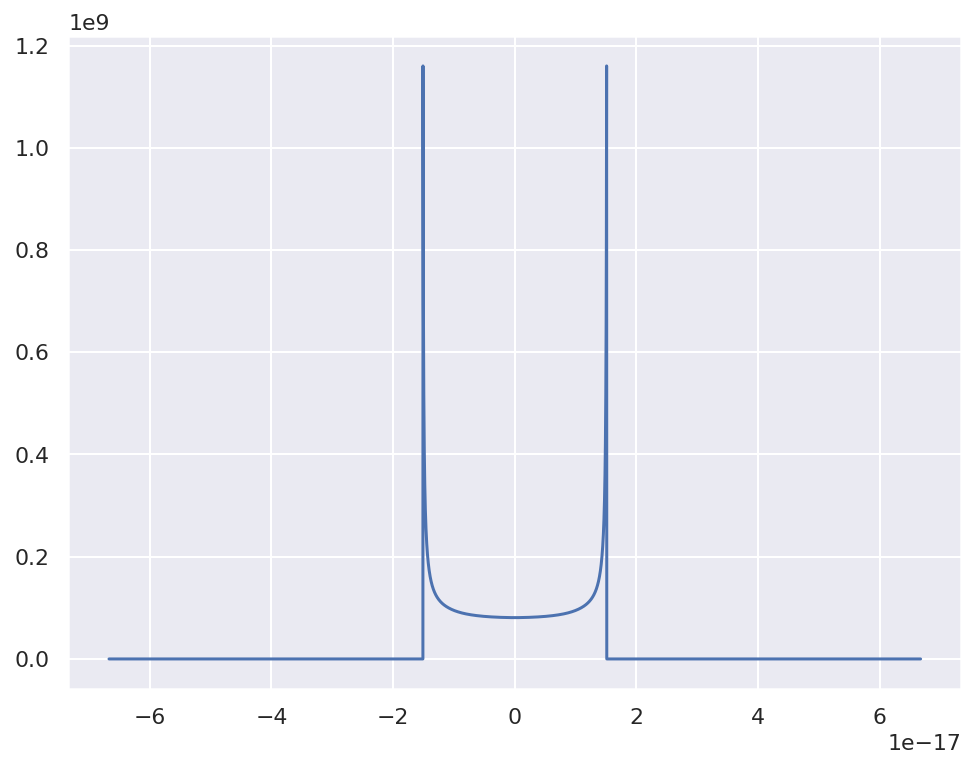

In [26]:
plt.plot(pdot, Paz)

In [27]:
# It's normalized if you add the factor of c back in

In [28]:
Paz_spl = UnivariateSpline(pdot*c,Paz)

In [29]:
Paz_spl.integral(-np.inf,np.inf)/2

0.497640566653554

In [30]:
from fitter.probabilities import likelihood_pulsar_spin, likelihood_pulsar_orbital

In [31]:
likelihood_pulsar_spin(
    model=m,
    pulsars=spins_data,
    Pdot_kde=None,
    cluster_μ=-2.53,
    coords=(-44, 305),
    mass_bin=-1,
)

/home/peter/research/GCfit/fitter/probabilities/pulsars.py:286: RuntimeWarning: invalid value encountered in log10
  Pdot_int = np.log10(Pdot_int)
/home/peter/anaconda3/envs/gcfit/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


811.178746238885